<h1>Project Telecom - Identifying the inefficient operators</h1>

<h2>Our Goals</h2>

<ul>
    <li>What do you want to achieve and why? - We want to develop a way to classify operators into 2 classes - efficient and inefficient based on 3 criteria.</li>
    <li>Who's interested in what you produce? - We develop this classification model for the managers overseeing operators</li>
    <li>What decisions will be made based on your analysis? - based on our model managers will decide which operators work more efficient than others and based on this adjust operators' composition within company</li>
</ul>

<h2>Steps to be done</h2>

<ol>
    <li>Data load and technical introduction(libraries to be used). Data set showing the logs of calls will be used to extract the values relevant for 3 criteria (total outcoming calls duration, total number of missed incoming calls (for those operators that were supposed to do outcoming calls), waiting duration for incoming calls) grouped by operator_id.</li>
    <li>Data pre-processing and EDA - data needs to be initially assessed, cleared from duplicates, missing values need to be treated and the data set to be prepared for further analysis.</li>
    <li>Based on the three items above then we will calculate composite equally weighted rating for each of the operators - the higher the rating the least efficient (more problematic) is the specific operator. Outcoming call duration should be contributing to rating with negative sign, while the other two will contribute with positive sign in accordance with the inefficiency criteria.</li>
    <li>Identify the efficient and inefficient operators - use prepared data to train classification model(s) and identifying the factors leading to specific classification. My suggestion is to treat the operators with top 15% ranking values as inefficient ones and label them respectively, while others will be considered efficient. Then I suggest to run logistic regression on the whole set and treat the classification as binary problem.</li>
    <li>Proposing hypotheses to be tested - the hypotheses to be tested should be aimed at investigating relationship between client's tariff and the number of missed calls, calls count, mean durations. For the purposes of testing, we can check 1) if the samples by tariff are distributed similarly using Wilconxon-Mann-Whitney Nonparametric Test; 2) if the mean criteria-related metrics mentioned above differ for operators serving users paying for different tariffs (we can perform t-tests for each pair A-B,B-C,A-C)</li>
    <li>Conducting hypotheses testing and assembling results into a presentation</li>
</ol>

<h2>Deliverables to complete</h2>

<ol>
    <li>Dashboard (either Tableau or Dash/python) - https://public.tableau.com/views/CallMeMaybe-Gleb_Zinkovskii_Dashboard/Dashboard1?:language=en&:display_count=y&publish=yes&:origin=viz_share_link </li>
    <li>Presentation with the results of the analysis https://docs.google.com/presentation/d/1_OJVlWJSOYt7RzEtlZZ3E9pfhRnIbzhVQwEc-uYPSek/edit?usp=sharing </li>
    <li>Jupyter notebook with supporting code and analysis - HERE BELOW</li>
</ol>

# Step 1 - Data load and technical introduction (libraries to be used)

In [1]:
#importing libraries that we need for EDA and visualization
import pandas as pd
import numpy as np
import math as mth
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats as st
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score

In [1]:
path_data_telecom = 'telecom_dataset_us.csv'
path_data_clients = 'telecom_clients_us.csv'

In [3]:
data_telecom = pd.read_csv(path_data_telecom)
data_telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
data_telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [5]:
data_clients = pd.read_csv(path_data_clients)
data_clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [6]:
data_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


# Conclusion

We can see that the telecom data set has instances with missing data - operator_id (15.16% of the total volume) and internal (<1% of the total volume). At the same time, clients data set does not seem to have missing data. Next, for both of the sets will be checked for duplicates and zero-values.

# Step 2 - Data pre-procesing and EDA

Let's check data on telecom for null values in any of the rows and columns:

In [7]:
data_telecom[data_telecom.isna().any(axis=1)]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27 00:00:00+03:00,in,False,NaN,True,2,0,39
53880,168601,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,19
53889,168603,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,30
53893,168606,2019-11-08 00:00:00+03:00,in,False,NaN,True,6,0,121


In [8]:
print('The amount of rows with null data is ', '{:.2%}'.format(data_telecom[data_telecom.isna().any(axis=1)].shape[0]/data_telecom.shape[0]))

The amount of rows with null data is  15.27%


In [9]:
data_telecom.loc[data_telecom.duplicated()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
44,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
51,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,1413,1473
...,...,...,...,...,...,...,...,...,...
53869,168601,2019-11-25 00:00:00+03:00,in,False,952914.0,False,7,1229,1282
53874,168601,2019-11-26 00:00:00+03:00,in,False,952914.0,False,4,539,562
53875,168601,2019-11-26 00:00:00+03:00,in,False,NaN,True,3,0,35
53885,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89


In [10]:
print('The amount of rows with duplicated data is ', '{:.2%}'.format(data_telecom[data_telecom.duplicated()].shape[0]/data_telecom.shape[0]))

The amount of rows with duplicated data is  9.09%


Let's get rid of the duplicates and see in more detail what we can do with the missing data and what is the distribution of the missin data.

In [11]:
data_telecom_clean = data_telecom.drop_duplicates().reset_index(drop=True)

In [12]:
data_telecom_clean[data_telecom.isna().any(axis=1)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,out,False,881278.0,True,3,0,29
17,166377,2019-08-07 00:00:00+03:00,out,False,880026.0,True,1,0,17
27,166377,2019-08-13 00:00:00+03:00,out,True,880026.0,True,2,0,23
...,...,...,...,...,...,...,...,...,...
48859,168579,2019-11-23 00:00:00+03:00,in,False,NaN,True,7,0,15
48864,168579,2019-11-26 00:00:00+03:00,in,False,NaN,True,4,0,10
48870,168583,2019-11-06 00:00:00+03:00,in,False,952126.0,False,1,52,75
48915,168601,2019-11-01 00:00:00+03:00,in,False,NaN,True,1,0,2


In [13]:
print('The amount of rows with null data is ', '{:.2%}'.format(data_telecom_clean[data_telecom_clean.isnull().any(axis=1)].shape[0]/data_telecom_clean.shape[0]))

The amount of rows with null data is  15.33%


In [14]:
data_telecom_clean.isnull().reset_index(drop=True).sum()

user_id                   0
date                      0
direction                 0
internal                110
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [15]:
data_telecom_clean['waiting_duration'] = data_telecom_clean['total_call_duration'] - data_telecom_clean['call_duration']

We see that the null values come from 2 sources - whether a call was internal/external and the operator_id. The main problem is that operator_id is a unique input that cannot be reconstructed on opeartor level, while fact whether a call was internal or external could be reconstructed based on the sample proportions. Therefore, I suggest to consider 2 subsets separately - one with observations where operator_id is missing and the second one with the rest. Next we need to identify the extent of the issue with missing data on external/internal data on each sub-sample - if the respective proportions of missing data are less than 10%, we will just drop those rows out of consideration. Otherwise, we will need to reconstruct the data using the proportions based on the rows having the external/internal features.

In [16]:
set_with_ids = data_telecom_clean.query('operator_id.notnull()').reset_index(drop=True)
set_no_ids = data_telecom_clean.query('operator_id.isnull()').reset_index(drop=True)

In [17]:
print('The amount of rows with null data is ', '{:.2%}'.format(set_with_ids[set_with_ids['internal'].isnull()].shape[0]/set_with_ids.shape[0]))

The amount of rows with null data is  0.13%


In [18]:
print('The amount of rows with null data is ', '{:.2%}'.format(set_no_ids[set_no_ids['internal'].isnull()].shape[0]/set_no_ids.shape[0]))

The amount of rows with null data is  0.74%


As we see from the above, we can drop the rows containing NaN values in external/internal feature in each of the subsets.

In [19]:
set_with_ids = set_with_ids.dropna(subset=['internal']).reset_index(drop=True)
set_no_ids = set_no_ids.dropna(subset=['internal']).reset_index(drop=True)

Once the subsets are cleared from duplicates and null values (I suggest to treat the zero values in the durations' features as valid data). Now, it is turn to optimize the data in terms of appropriate data types:

In [20]:
set_with_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 10 columns):
user_id                41491 non-null int64
date                   41491 non-null object
direction              41491 non-null object
internal               41491 non-null object
operator_id            41491 non-null float64
is_missed_call         41491 non-null bool
calls_count            41491 non-null int64
call_duration          41491 non-null int64
total_call_duration    41491 non-null int64
waiting_duration       41491 non-null int64
dtypes: bool(1), float64(1), int64(5), object(3)
memory usage: 2.9+ MB


In [21]:
set_with_ids['date'] = pd.to_datetime(set_with_ids['date'])
set_with_ids['direction'] = set_with_ids['direction'].astype('category')
set_with_ids['internal'] = set_with_ids['internal'].astype('bool')
set_with_ids['operator_id'] = set_with_ids['operator_id'].astype('int64')
set_with_ids['is_missed_call'] = set_with_ids['is_missed_call'].astype('bool')
set_with_ids['calls_count'] = set_with_ids['calls_count'].astype('int32')
set_with_ids = pd.get_dummies(set_with_ids)

In [22]:
set_no_ids['date'] = pd.to_datetime(set_no_ids['date'])
set_no_ids['direction'] = set_no_ids['direction'].astype('category')
set_no_ids['internal'] = set_no_ids['internal'].astype('bool')
set_no_ids['is_missed_call'] = set_no_ids['is_missed_call'].astype('bool')
set_no_ids['calls_count'] = set_no_ids['calls_count'].astype('int32')
set_no_ids = pd.get_dummies(set_no_ids)

In [23]:
#let's drop the operator_id
set_no_ids.drop(['operator_id'], axis=1, inplace=True)

Let's confirm the data integrity and completeness for the clients data base:

In [24]:
data_clients[data_clients.isna().any(axis=1)]

,user_id,tariff_plan,date_start


In [25]:
data_clients.loc[data_clients.duplicated()]

,user_id,tariff_plan,date_start


Clients information data set seem not to have any issues.

# Conclusion
The calls log data set was cleaned from duplicates, optimized for memory usage through conversion of features into appropriate types and enriched for dummy variables based on categorical variables for further processing. The clients data set did not contain any duplicates, NaN or other issues.

# Step 3 - Identifying efficient algorithm

An operator is considered ineffective if they have 1) a large number of missed incoming calls (internal and external) and 2) a long waiting time for incoming calls, 3) if an operator is supposed to make outgoing calls, a small number of them is also a sign of ineffectiveness. Let's assume that operators that were not supposed to do outgoing calls did not do it, and those that actually called were supposed to do it. To be able to classify operators as efficient and inefficient I suggest to have some composite measure representing an operator's performance which will become the target variable for the classification problem.

In [26]:
set_with_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 11 columns):
user_id                41491 non-null int64
date                   41491 non-null datetime64[ns, pytz.FixedOffset(180)]
internal               41491 non-null bool
operator_id            41491 non-null int64
is_missed_call         41491 non-null bool
calls_count            41491 non-null int32
call_duration          41491 non-null int64
total_call_duration    41491 non-null int64
waiting_duration       41491 non-null int64
direction_in           41491 non-null uint8
direction_out          41491 non-null uint8
dtypes: bool(2), datetime64[ns, pytz.FixedOffset(180)](1), int32(1), int64(5), uint8(2)
memory usage: 2.2 MB


In [27]:
set_with_ids['waiting_duration_incoming'] = set_with_ids['waiting_duration']*set_with_ids['direction_in']
set_with_ids['call_duration_outcoming'] = set_with_ids['call_duration']*set_with_ids['direction_out']
set_with_ids['is_missed_call_incoming'] = set_with_ids['is_missed_call']*set_with_ids['direction_in']
set_with_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 14 columns):
user_id                      41491 non-null int64
date                         41491 non-null datetime64[ns, pytz.FixedOffset(180)]
internal                     41491 non-null bool
operator_id                  41491 non-null int64
is_missed_call               41491 non-null bool
calls_count                  41491 non-null int32
call_duration                41491 non-null int64
total_call_duration          41491 non-null int64
waiting_duration             41491 non-null int64
direction_in                 41491 non-null uint8
direction_out                41491 non-null uint8
waiting_duration_incoming    41491 non-null int64
call_duration_outcoming      41491 non-null int64
is_missed_call_incoming      41491 non-null uint8
dtypes: bool(2), datetime64[ns, pytz.FixedOffset(180)](1), int32(1), int64(7), uint8(3)
memory usage: 2.9 MB


In [28]:
classification_set_with_ids = set_with_ids.groupby('operator_id').agg({'call_duration_outcoming':'sum',
                                         'is_missed_call_incoming':'sum', 
                                         'waiting_duration_incoming':'sum'}).reset_index()

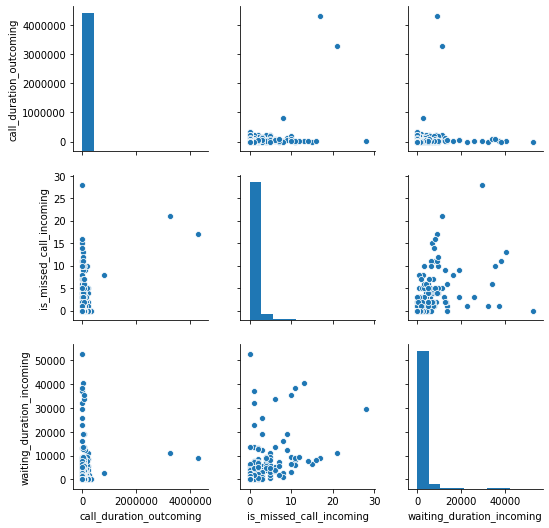

In [29]:
sns.pairplot(classification_set_with_ids.drop(['operator_id'], axis=1))

In [30]:
classification_set_with_ids['call_duration_outcoming'] = classification_set_with_ids['call_duration_outcoming']/3600
classification_set_with_ids['waiting_duration_incoming'] = classification_set_with_ids['waiting_duration_incoming']/3600

In [31]:
classification_set_with_ids['rating'] = (classification_set_with_ids['is_missed_call_incoming'] - classification_set_with_ids['call_duration_outcoming'] + classification_set_with_ids['waiting_duration_incoming'])/3
classification_set_with_ids.describe()

,operator_id,call_duration_outcoming,is_missed_call_incoming,waiting_duration_incoming,rating
count,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000
mean,925517.543956,8.248845,0.626374,0.313466,-2.436335
std,22854.532209,47.356227,2.041180,1.089645,15.501855
min,879896.000000,0.000000,0.000000,0.000000,-392.084630
25%,906393.500000,0.000000,0.000000,0.000000,-1.608611
50%,925105.000000,0.541250,0.000000,0.019583,-0.084861
75%,944211.500000,5.960694,0.000000,0.159722,0.004074
max,973286.000000,1195.758611,28.000000,14.665278,10.952315


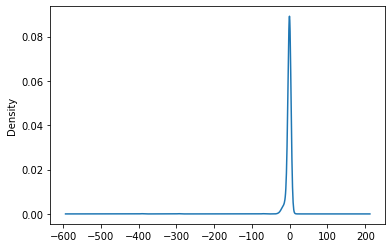

In [32]:
classification_set_with_ids['rating'].plot(kind='kde')

In [33]:
#let's identify the top 15% threshold of the observations by rating that we will consider further as inefficient operators
classification_set_with_ids.sort_values(by='rating', ascending=False)['rating'].quantile(q=0.85)

0.04836574074074074

Based on the above, we can say that truely outlying observations in terms of rating (the higher the less efficient an operator is) are the ones with rating above 0.05. Therefore, I suggest to filter out all operators above the above threshold.

In [34]:
#let's encode inefficient operators (1) and efficient operators (0)
classification_set_with_ids['efficient_status'] = np.where(classification_set_with_ids['rating']>=0.05, 1,0)

In [35]:
classification_set_with_ids.efficient_status.value_counts()

0    930
1    162
Name: efficient_status, dtype: int64

Here for example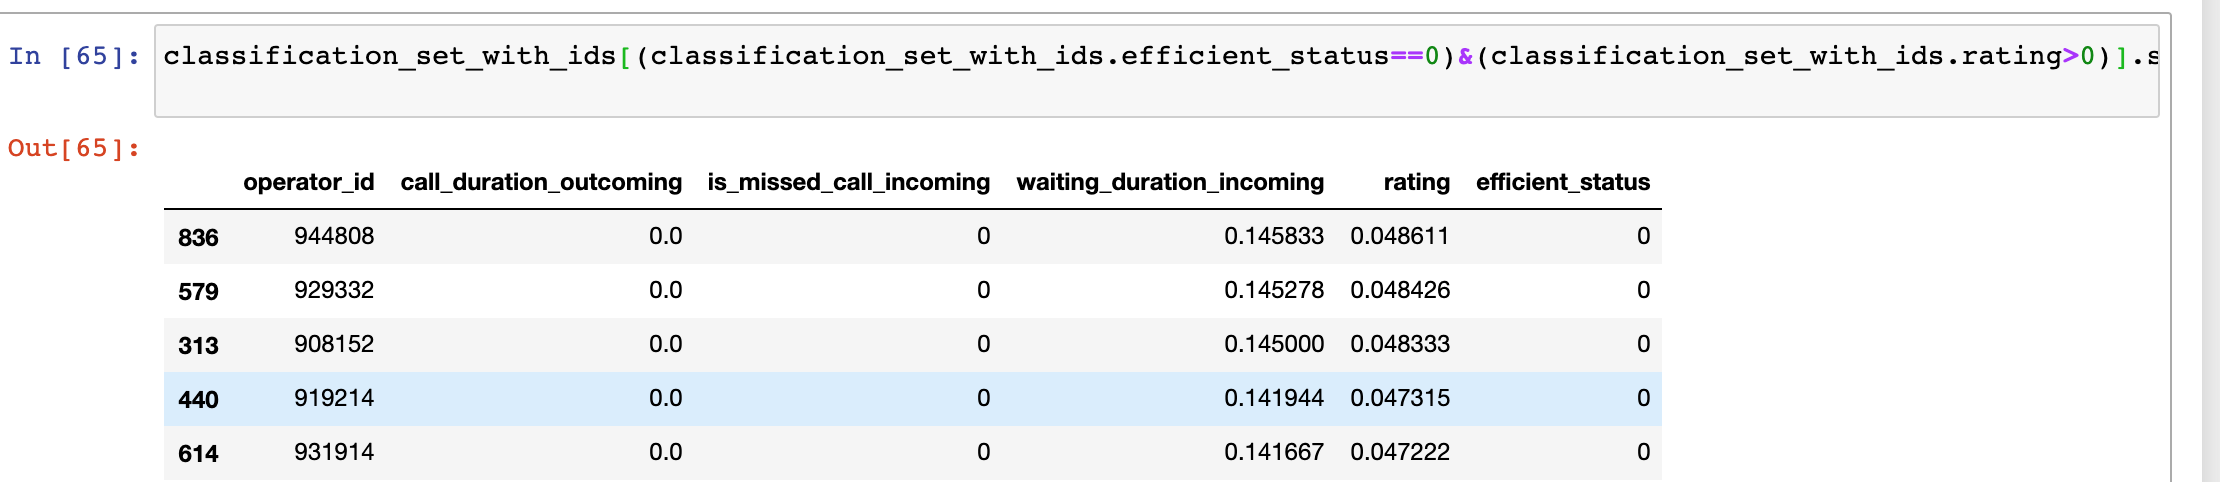

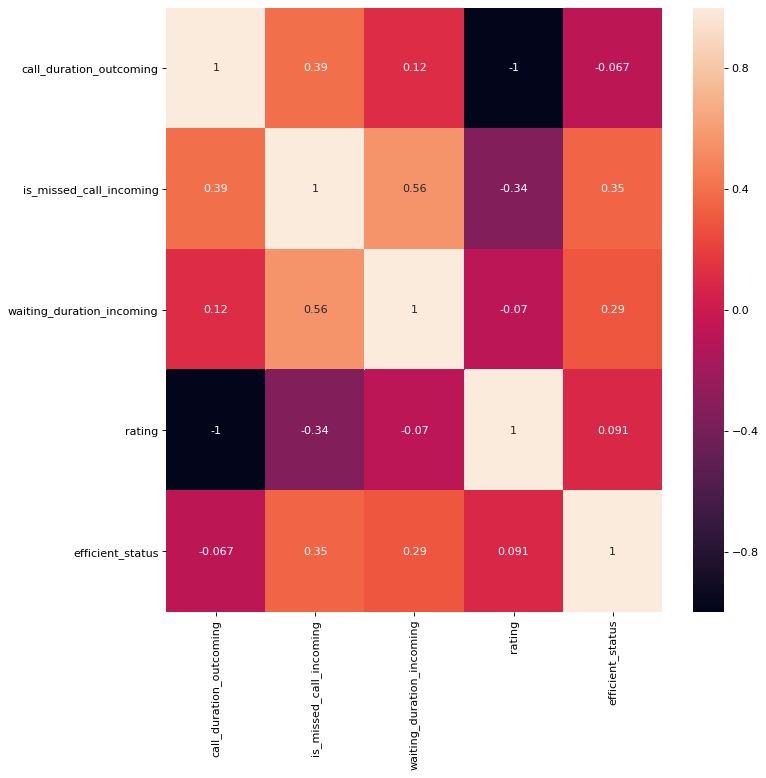

In [36]:
#let's plot a heatmap of the correlation matrix
plt.figure(figsize=(10,10), dpi=80)
sns.heatmap(classification_set_with_ids.drop('operator_id',axis=1).corr(), annot=True)

In [37]:
# dividing the original set into target variable and features matrix - operator_id and rating are dropped for further processing 
X = classification_set_with_ids.drop(['efficient_status', 'operator_id','rating'], axis=1)
y = classification_set_with_ids['efficient_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [38]:
# let's define the helper function that will output our metrics
def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [39]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
print('Classification report:\n', classification_report(y_test, y_predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted, labels=[0, 1])
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       187
           1       1.00      0.78      0.88        32

    accuracy                           0.97       219
   macro avg       0.98      0.89      0.93       219
weighted avg       0.97      0.97      0.97       219

Confusion matrix:
 [[187   0]
 [  7  25]]


In [40]:
#let's scale the data
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) # train the scaler and transform the matrix for the train set

# apply standardization to the feature matrix for the test set
X_test_st = scaler.transform(X_test)

In [41]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_st, y_train)
y_predicted = model.predict(X_test_st)
print('Classification report:\n', classification_report(y_test, y_predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted, labels=[0, 1])
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       187
           1       0.88      0.22      0.35        32

    accuracy                           0.88       219
   macro avg       0.88      0.61      0.64       219
weighted avg       0.88      0.88      0.85       219

Confusion matrix:
 [[186   1]
 [ 25   7]]


In [42]:
# let's define the algorithm for the new random forest model
rf_model =  RandomForestClassifier(n_estimators = 7, random_state=0)
# and train the random forest model
rf_model.fit(X_train_st, y_train)
# and use the trained model to make predictions
rf_predictions = rf_model.predict(X_test_st)# write your code here
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]# write your code here
# printing all metrics
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Metrics for random forest:')

Metrics for random forest:
	Accuracy: 0.99
	Precision: 0.97
	Recall: 0.97


# Conclusion

We see from the above, that the logistic model yields good results for train data before being scaled, but drops in efficiency once scaling is applied. Finally, Random forest generator shows the best results for the classification of operators into efficient/not efficient based on the prescribed criteria.

# Step 4-5. Formulating and Testing Hypotheses.

Let's test first whether the number of calls in each of tariff group is distributed in the same shape using Wilconxon-Mann-Whitney Nonparametric Test. For that we will join the two tables in such a way that each entry can be identified by tariff and then set could be separated by it into sub-samples.

In [43]:
#we can drop here the operator_id, because we do not need to aggregate the entries
df_combined = data_telecom_clean.drop('operator_id', axis=1).merge(data_clients, how ='left', on='user_id')

In [44]:
df_combined.head()

,user_id,date,direction,internal,is_missed_call,calls_count,call_duration,total_call_duration,waiting_duration,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,True,2,0,4,4,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,True,3,0,5,5,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,True,1,0,1,1,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,True,False,1,10,18,8,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,True,3,0,25,25,B,2019-08-01


In [45]:
#let's divide the data set into samples based on tariff
sample_a = df_combined.query('tariff_plan=="A"').reset_index(drop=True)
sample_b = df_combined.query('tariff_plan=="B"').reset_index(drop=True)
sample_c = df_combined.query('tariff_plan=="C"').reset_index(drop=True)

Now, we can run the tests for each of the feature from each pair of samples in loop and see whether we can see immediate statitstical difference between the user calling patterns depending on his/her tariff. If user groups by tariff differ in calling patterns we cannot associate the potential impact on the operator classification criteria and the final efficiency rank of a specific operator because he had served user(s) from tariff with adverse calling patters. Otherwise, if we spot a feature for which we cannot claim difference in distribution we will run t-test for sample means or sample proportion equality to see how big is the difference and hence how big could be potential impact. In short - if user calling patterns are not similar and each operator has chances for similar exposure to all groups of users, then the impact on the criteria is similar for all of the operators and only their personal performance capability will matter. 

In [46]:
alpha = .05 #significance level
for i in ['calls_count', 'call_duration', 'total_call_duration', 'waiting_duration']:
    results = st.mannwhitneyu(sample_a[i], sample_b[i])
    print('p-value: ', results.pvalue)
    if (results.pvalue < alpha):
        print("Null hypothesis rejected: the difference is statistically significant for feature", i)
    else:
        print("Failed to reject the null hypothesis: we can't make conclusions about the difference for feature", i) 

p-value:  1.9992778046916053e-144
Null hypothesis rejected: the difference is statistically significant for feature calls_count
p-value:  5.514671430661601e-21
Null hypothesis rejected: the difference is statistically significant for feature call_duration
p-value:  5.69285260033788e-108
Null hypothesis rejected: the difference is statistically significant for feature total_call_duration
p-value:  3.84780792834177e-117
Null hypothesis rejected: the difference is statistically significant for feature waiting_duration


With this test we are checking that for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X.

We can make conclusion that there is difference between distributions for samples from tariff A and B in each of the features.

In [47]:
alpha = .05 #significance level
for i in ['calls_count', 'call_duration', 'total_call_duration', 'waiting_duration']:
    results = st.mannwhitneyu(sample_a[i], sample_c[i])
    print('p-value: ', results.pvalue)
    if (results.pvalue < alpha):
        print("Null hypothesis rejected: the difference is statistically significant for feature", i)
    else:
        print("Failed to reject the null hypothesis: we can't make conclusions about the difference for feature", i) 

p-value:  3.3611594040431287e-149
Null hypothesis rejected: the difference is statistically significant for feature calls_count
p-value:  5.089726233733631e-33
Null hypothesis rejected: the difference is statistically significant for feature call_duration
p-value:  2.2086268389542628e-162
Null hypothesis rejected: the difference is statistically significant for feature total_call_duration
p-value:  4.1934491051105415e-148
Null hypothesis rejected: the difference is statistically significant for feature waiting_duration


We can make conclusion that there is difference between distributions for samples from tariff A and C in each of the feature distributions.

In [48]:
alpha = .05 #significance level
for i in ['calls_count', 'call_duration', 'total_call_duration', 'waiting_duration']:
    results = st.mannwhitneyu(sample_b[i], sample_c[i])
    print('p-value: ', results.pvalue)
    if (results.pvalue < alpha):
        print("Null hypothesis rejected: the difference is statistically significant for feature", i)
    else:
        print("Failed to reject the null hypothesis: we can't make conclusions about the difference for feature", i) 

p-value:  0.38927116783795307
Failed to reject the null hypothesis: we can't make conclusions about the difference for feature calls_count
p-value:  0.0033571737288529083
Null hypothesis rejected: the difference is statistically significant for feature call_duration
p-value:  5.942864116088894e-09
Null hypothesis rejected: the difference is statistically significant for feature total_call_duration
p-value:  0.0003696337907546386
Null hypothesis rejected: the difference is statistically significant for feature waiting_duration


We can make conclusion that there is difference between distributions for samples from tariff B and C for all features, except for calls_count feature. We can run further test for sample means equality to verify if there is a statistically significant difference or not.

Now we can statistically verify that there is a difference between number of missed calls for users on tariffs B and C and hence we should expect more inefficiency from operators serving users from tariff C.

In [50]:
#let's verify that sample means and variances are similar or not before T-test:
print(sample_b.calls_count.describe(),'\n', sample_c.calls_count.describe())

count    17237.000000
mean         9.489644
std         18.534434
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max        714.000000
Name: calls_count, dtype: float64 
 count    18209.000000
mean        11.175023
std         52.336108
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max       4817.000000
Name: calls_count, dtype: float64


In [51]:
#we see that we should assume unequal variances:
alpha = .05
st.ttest_ind(sample_b.calls_count, sample_c.calls_count, equal_var = False)
print('p-value: ', p_value)

if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the sample means")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider the sample means different")

p-value:  0.869753098054032
Failed to reject the null hypothesis: there is no reason to consider the sample means different


<em>In terms of the assumption of normality for the t-test to be carried out - we are testing here sample mean (I think we can assume that users from different tariffs could be treated as independent populations in terms of call features, unless we can directly connect two parties involved in one call being on these 2 tariffs + the data covers specific time frame, so it could be considered as sample from population). Therefore, according to Central limit theorem the sample means will be normally distributed around population mean which is needed for t-test. At the same time we have high number of observations in the samples which pushes the degrees of freedom further + we can assume that the samples and proportions are unpaired. Therefore, I proceeded to test the sample means and proportions.</em>

We can see here that we do not have statistical evidence that the means are different - my mistake, but it makes sense with the non-parametric test results. Thus, it it means that if an operator serves with similar chances both users from tariff B and C, still the calls_count feature values could be expected not to be significantly different from each other to say that fact of serving B tariff could have more impact on performance rather than serving C tariff users.

# Conclusion

Based on the observations above we can say that the user behaviour in terms of calls parameters between tariffs A and B, A and C is generally different. There are similarities in distribution for calls_count features observed and verified for users on tariffs B and C, but it is not statistically significant in terms of mean calls count to have impact on efficiency evaluation.